In [ ]:
pip install captcha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 33.2 MB/s 


In [ ]:
pip install Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 41.0 MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19495 sha256=f79c9b7d84600108b7dde4b76e7aadd5f4e2bd988be4c889961f61314366be4a
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built Image


In [ ]:
from fastai.imports import *

In [ ]:
from itertools import groupby

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from captcha.image import ImageCaptcha

image = ImageCaptcha()

for chars in range(0, 9984):
    image.write(f'{chars:>04}', f'sample_data/captchas/{chars:>04}.png')

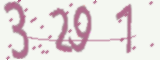

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
im=cv2.imread('sample_data/captchas/3297.png')
cv2_imshow(im)

In [ ]:
st=f'{chars:>04}'
st

'9983'

In [ ]:
# Imports PIL module 
from PIL import Image
class CaptchaDataset(Dataset):
    """CAPTCHA dataset."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = list(Path(root_dir).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])

        if self.transform:
            image = self.transform(image)
        
        label_sequence = [int(c) for c in self.image_paths[index].stem]
        return (image, torch.tensor(label_sequence))
        print(label_sequence)
    
    def __len__(self):
        return len(self.image_paths)

In [ ]:
import cv2
imagep=cv2.imread('sample_data/captchas/0027.png')
img_size=imagep.shape
print(img_size)

(60, 160, 3)


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

dataset = CaptchaDataset(root_dir='sample_data/captchas', transform=transform)

dataloader = DataLoader(dataset, batch_size=9984)

for batch_index, (inputs, labels) in enumerate(dataloader):
    print(f'Mean: {inputs.mean()}, Variance: {inputs.std()}')

Mean: 0.8758270144462585, Variance: 0.15317463874816895


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(
        0.875748336315155, 0.15336987376213074
    )
])

dataset = CaptchaDataset(root_dir='sample_data/captchas', transform=transform)

train_dataset, test_dataset = random_split(dataset, [128*64, 28*64])  # total images: 9984

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

class StackedLSTM(nn.Module):
    def __init__(self, input_size=60, output_size=11, hidden_size=512, num_layers=2):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(hidden_size, output_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
 
    def forward(self, inputs, hidden):
        ot=inputs.shape
        batch_size, seq_len, input_size = inputs.shape
        outputs, hidden = self.lstm(inputs, hidden)
        
        outputs = self.dropout(outputs)
        outputs = torch.stack([self.fc(outputs[i]) for i in range(width)])
        
        outputs = F.log_softmax(outputs, dim=2)
        #ot=outputs.shape
        return outputs, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data 
        return (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        

net = StackedLSTM().to(device)

In [ ]:
criterion = nn.CTCLoss(blank=10)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BLANK_LABEL = 10

In [ ]:
net.train()  # set network to training phase
    
epochs = 30
batch_size = 64

# for each pass of the training dataset
for epoch in range(epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    
    h = net.init_hidden(batch_size)

    # for each batch of training examples
    for batch_index, (inputs, targets) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        batch_size, channels, height, width = inputs.shape

        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        optimizer.zero_grad()  # zero the parameter gradients
        outputs, h = net(inputs, h)  # forward pass

        # compare output with ground truth
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets, input_lengths, target_lengths)

        loss.backward()  # backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), 10)  # clip gradients
        optimizer.step()  # update network weights

        # record statistics
        prob, max_index = torch.max(outputs, dim=2)
        train_loss += loss.item()
        train_total += len(targets)

        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            if pred == target:
                train_correct += 1

        # print statistics every 10 batches
        if (batch_index + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, ' +
                  f'Batch {batch_index + 1}/{len(train_dataloader)}, ' +
                  f'Train Loss: {(train_loss/1):.5f}, ' +
                  f'Train Accuracy: {(train_correct/train_total):.5f}') 
            train_loss, train_correct, train_total = 0, 0, 0

Epoch 1/30, Batch 10/128, Train Loss: 448.07222, Train Accuracy: 0.00000
Epoch 1/30, Batch 20/128, Train Loss: 56.50127, Train Accuracy: 0.00000
Epoch 1/30, Batch 30/128, Train Loss: 30.96706, Train Accuracy: 0.00000
Epoch 1/30, Batch 40/128, Train Loss: 27.58424, Train Accuracy: 0.00000
Epoch 1/30, Batch 50/128, Train Loss: 27.22814, Train Accuracy: 0.00000
Epoch 1/30, Batch 60/128, Train Loss: 27.11596, Train Accuracy: 0.00000
Epoch 1/30, Batch 70/128, Train Loss: 27.07832, Train Accuracy: 0.00000
Epoch 1/30, Batch 80/128, Train Loss: 27.07215, Train Accuracy: 0.00000
Epoch 1/30, Batch 90/128, Train Loss: 27.05075, Train Accuracy: 0.00000
Epoch 1/30, Batch 100/128, Train Loss: 27.04190, Train Accuracy: 0.00000
Epoch 1/30, Batch 110/128, Train Loss: 27.02683, Train Accuracy: 0.00000
Epoch 1/30, Batch 120/128, Train Loss: 27.02276, Train Accuracy: 0.00000
Epoch 2/30, Batch 10/128, Train Loss: 27.00269, Train Accuracy: 0.00000
Epoch 2/30, Batch 20/128, Train Loss: 26.98594, Train Accura

In [ ]:
import torch
h = net.init_hidden(batch_size)  # init hidden state
net.eval()
p=[]
o=[]
test_loss = 0
test_correct = 0
test_total = len(test_dataloader.dataset) 
test_running_corrects = 0.0

with torch.no_grad():  # detach gradients so network runs faster
    
    # for each batch of testing examples
    for batch_index, (inputs, targets) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        batch_size, channels, height, width = inputs.shape
        
        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        outputs, h = net(inputs, h)  # forward pass
        
        # record loss
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        test_loss += loss.item()
        
        # compare prediction with ground truth
        prob, max_index = torch.max(outputs, dim=2)
        
        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            for i in pred:
                p.append(i)
            for i in target:
                o.append(i)
            o.append(c for c in target)
            if pred == target:
                test_correct += 1

print(f'Test Loss: {(test_loss/len(test_dataloader)):.5f}, ' +
      f'Test Accuracy: {(test_correct/test_total):.5f} ' +
      f'({test_correct}/{test_total})')

Test Loss: 0.09598, Test Accuracy: 0.93136 (1669/1792)


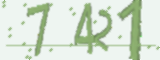

Predicted text: [7, 4, 2, 1]


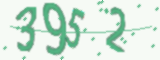

Predicted text: [3, 9, 5, 2]


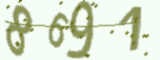

Predicted text: [8, 6, 9, 1]


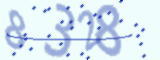

Predicted text: [8, 3, 2, 1, 8]


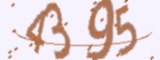

Predicted text: [4, 3, 9, 5]


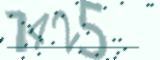

Predicted text: [1, 4, 2, 5]


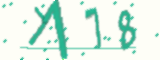

Predicted text: [7, 1, 7, 8]


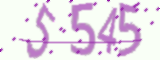

Predicted text: [5, 5, 4, 5]


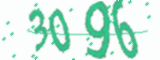

Predicted text: [3, 0, 9, 6]


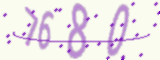

Predicted text: [7, 6, 8, 0]


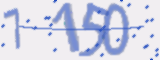

Predicted text: [7, 1, 1, 5, 0]


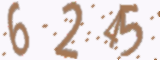

Predicted text: [6, 2, 4, 5]


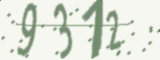

Predicted text: [9, 3, 1, 2]


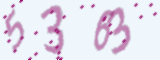

Predicted text: [5, 3, 6, 3]


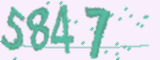

Predicted text: [5, 8, 4, 1]


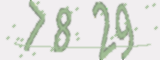

Predicted text: [7, 8, 2, 9]


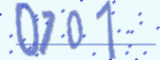

Predicted text: [0, 1, 0, 7]


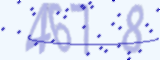

Predicted text: [4, 6, 7, 8]


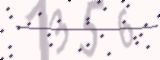

Predicted text: [1, 1, 5, 6]


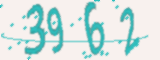

Predicted text: [3, 9, 6, 2]


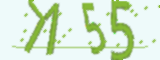

Predicted text: [7, 1, 5, 5]


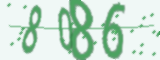

Predicted text: [8, 0, 8, 6]


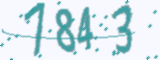

Predicted text: [7, 8, 4, 3]


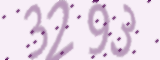

Predicted text: [3, 2, 9, 3]


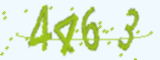

Predicted text: [4, 4, 6, 3]


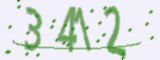

Predicted text: [3, 4, 1, 2]


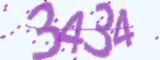

Predicted text: [3, 4, 3, 4]


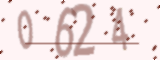

Predicted text: [0, 6, 2, 4]


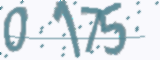

Predicted text: [0, 1, 7, 5]


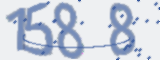

Predicted text: [1, 5, 8, 8]


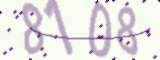

Predicted text: [8, 1, 0, 8]


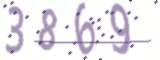

Predicted text: [3, 8, 6, 9]


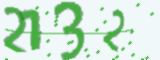

Predicted text: [2, 1, 3, 2]


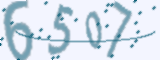

Predicted text: [6, 5, 0, 7]


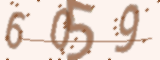

Predicted text: [6, 0, 5, 9]


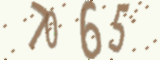

Predicted text: [7, 0, 6, 5]


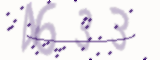

Predicted text: [4, 6, 5, 3]


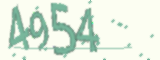

Predicted text: [4, 9, 5, 4]


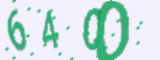

Predicted text: [6, 4, 0, 0]


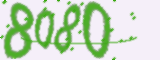

Predicted text: [8, 0, 8, 0]


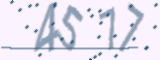

Predicted text: [4, 5, 7, 7]


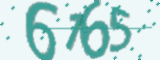

Predicted text: [6, 1, 6, 5]


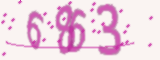

Predicted text: [6, 8, 6, 3]


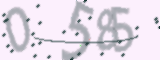

Predicted text: [0, 5, 8, 6]


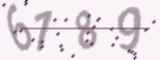

Predicted text: [6, 1, 8, 9]


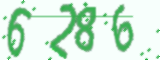

Predicted text: [6, 2, 8, 6]


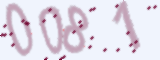

Predicted text: [0, 0, 8, 1]


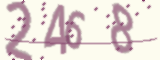

Predicted text: [2, 4, 6, 8]


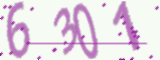

Predicted text: [6, 3, 0, 1]


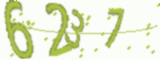

Predicted text: [6, 2, 3, 7]


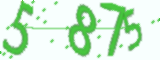

Predicted text: [5, 8, 7, 5]


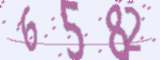

Predicted text: [6, 5, 8, 2]


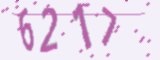

Predicted text: [6, 2, 1, 7]


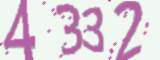

Predicted text: [4, 3, 3, 2]


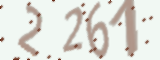

Predicted text: [2, 2, 6, 1]


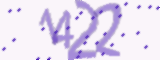

Predicted text: [1, 4, 2, 2]


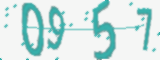

Predicted text: [0, 9, 5, 7]


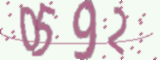

Predicted text: [0, 5, 9, 2]


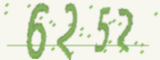

Predicted text: [6, 2, 5, 2]


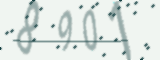

Predicted text: [8, 9, 0, 1]


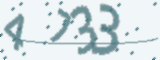

Predicted text: [4, 7, 3, 3]


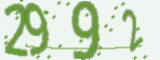

Predicted text: [2, 9, 9, 2]


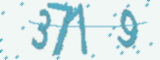

Predicted text: [3, 7, 1, 9]


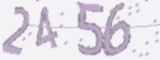

Predicted text: [2, 4, 5, 6]


In [ ]:
import torch
h = net.init_hidden(batch_size)  # init hidden state
net.eval()
p=[]
o=[]
test_loss = 0
test_correct = 0
test_total = len(test_dataloader.dataset) 
test_running_corrects = 0.0
count=0
with torch.no_grad():  # detach gradients so network runs faster
    
    # for each batch of testing examples
    for batch_index, (inputs, targets) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        batch_size, channels, height, width = inputs.shape
        
        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        outputs, h = net(inputs, h)  # forward pass
        
        # record loss
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        test_loss += loss.item()
        
        # compare prediction with ground truth
        prob, max_index = torch.max(outputs, dim=2)
        
        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            t = ""
            for digit in target:
              t += str(digit)
            im=cv2.imread('sample_data/captchas/{}.png'.format(t))
            cv2_imshow(im)
            print("Predicted text:",pred)
            count=count+1
        if count>50:
          break

Target: 3952


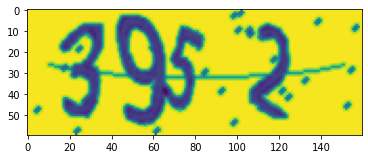

In [ ]:
data_iterator = iter(test_dataloader)
inputs, targets = data_iterator.next()

i = 1

image = inputs[i,0,:,:]

print(f"Target: {''.join(map(str, targets[i].numpy()))}")
plt.imshow(image)

In [ ]:
inputs = inputs.to(device)

batch_size, channels, height, width = inputs.shape
h = net.init_hidden(batch_size)

inputs = (inputs
          .permute(3, 0, 2, 1)
          .contiguous()
          .view((width, batch_size, -1)))

# get prediction
outputs, h = net(inputs, h)  # forward pass
prob, max_index = torch.max(outputs, dim=2)
raw_pred = list(max_index[:, i].cpu().numpy())

# print raw prediction with BLANK_LABEL replaced with "-"
print('Raw Prediction: ' + ''.join([str(c) if c != BLANK_LABEL else '-' for c in raw_pred]))

pred = [str(c) for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
print(f"Prediction: {''.join(pred)}")


Raw Prediction: ---------------------------333---------------------------999------------------55----------------------------------------222-------------------------------------
Prediction: 3952


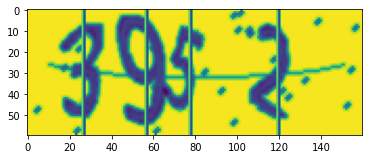

In [ ]:
#The line indicates the position at which the model predicted the number
line_mask = [(a == BLANK_LABEL) & (b != BLANK_LABEL) for a, b in zip(raw_pred, raw_pred[1:])]
indices = [i for i, x in enumerate(line_mask) if x]

annotated_image = image.clone()
for index in indices:
    annotated_image[:, index] = 0
    annotated_image[:, index+1] = -2

plt.imshow(annotated_image)